# Support vector machines

Support vector machines have supplanted forms of linear learning due to their emphasis upon separating classes and manipulating that separation carefully. Let's study some limits of the model. 

In [1]:
# Run this first to load all libraries. 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
import math
from sklearn.utils import shuffle

In [4]:
# Here's a simple visualizer.   
def make_meshgrid(x, y, h=1):
    x_min = x.min() - 1
    x_max = x.max() + 1
    y_min = y.min() - 1
    y_max = y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, model, xx, yy, **params):
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)

def visualize(model, df):
    X = df.loc[:, ['x', 'y']].values
    y = df.loc[:, 'label'].values
    X0, X1 = X[:, 0], X[:, 1]
    fig, ax = plt.subplots()
    # plot contour lines for predictions 
    xx, yy = make_meshgrid(np.array([0, 100]), np.array([0, 500]), 1)
    plot_contours(ax, model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=list(map(lambda x: 'b' if x<2 else 'r', y)))
    plt.show()

*Question 1:* Consider the following data set:  

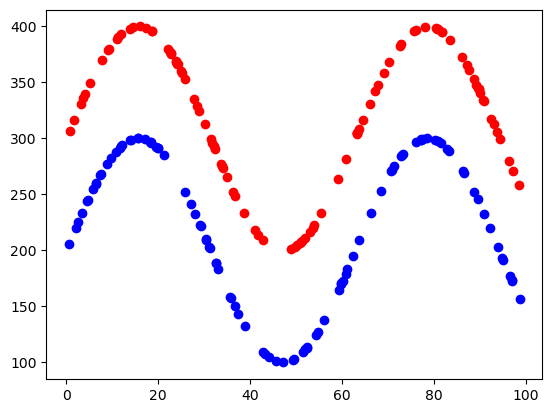

In [3]:
# Let's set up a very weird data set. 
def f1(x): 
    return np.sin(x/10) * 100 + 200
def f2(x): 
    return np.sin(x/10) * 100 + 300
np.random.seed(42)
x1 = np.random.uniform(0, 100, 100)
y1 = f1(x1)
x2 = np.random.uniform(0, 100, 100)
y2 = f2(x2)

df1 = pd.DataFrame({'x': x1, 'y': y1, 'label': 1})
df2 = pd.DataFrame({'x': x2, 'y': y2, 'label': 2})
df = pd.concat([df1, df2])
df = shuffle(df)
plt.plot(x1, y1, 'bo')
plt.plot(x2, y2, 'ro')                  

What decision function would optimally separate these populations? 

A nonlinear decision function, specifically one that can model complex, periodic patterns, is what we need. A support vector machine with a Radial Basis Function (RBF) kernel would likely perform well here. The RBF kernel is well-suited for this task because it allows the decision boundary to curve in complex ways, accommodating the sinusoidal separation between the two populations.

*Question 2:* Fit an `svm.SVC` model `model1` to this data. You may use any predefined kernel. You are allowed 5 classification errors. Try to make as few as possible. 

In [40]:
# make model1 a fitted model
from sklearn.metrics import accuracy_score

# BEGIN SOLUTION
# The SVC model with an RBF kernel
model1 = svm.SVC(kernel='rbf', C=10000, gamma='scale')  # 'C' and 'gamma' are tuned for better accuracy

# Prepare the data
X = df[['x', 'y']].values
y = df['label'].values

# Fit the model to the data
model1.fit(X, y)

# Predict labels on the same data to check accuracy
y_pred = model1.predict(X)
errors = (y != y_pred).sum()  # Count the # of errors
errors
# END SOLUTION 

3

In [41]:
assert df.shape[0] == 200

In [42]:
assert isinstance(model1, svm._classes.SVC)

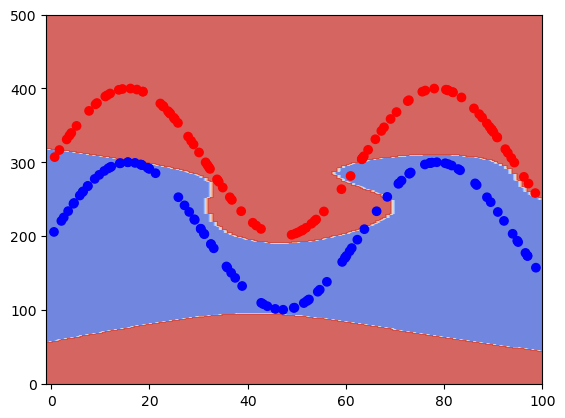

8 classification errors


In [43]:
visualize(model1, df)
import math
count = 0
for i in np.arange(0, 100):
    if model1.predict([[i, f1(i)]]) != [1]: 
        count += 1
for i in np.arange(0, 100):
    if model1.predict([[i, f2(i)]]) != [2]: 
        count += 1
print("{} classification errors".format(count))

*Question 3:* What are the obvious drawbacks to `model1`? 

It has an overly complex and jagged decision boundary which is the result of overfitting from a very high c parameter. This overfitting means the volume would do a poor job generalizing to new/unseen data points in the population.

*Question 4:* Consider the following data set:  

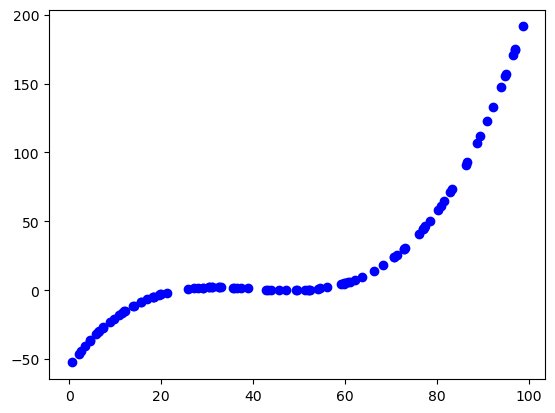

In [45]:
# Let's set up another very weird data set. 
def f3(x): 
    xtemp = (x - 50) / 10
    return xtemp*xtemp*xtemp + 3*xtemp*xtemp + xtemp
np.random.seed(42)
x3 = np.random.uniform(0, 100, 100)
y3 = f3(x3)

df3 = pd.DataFrame({'x': x3, 'y': y3})

plt.plot(x3, y3, 'bo')                  

What decision function would optimally identify this population of data points? 

It resembles a cubic polynomial function centered around x=50 so we might want to use a polynomial kernal of degree 3 to capture the relationship. 

In [61]:
# let's create an appropriate visualizer for one-class SVM. 
def visualize_one(model, df):
    X = df.loc[:, ['x', 'y']].values
    X0, X1 = X[:, 0], X[:, 1]
    fig, ax = plt.subplots()
    # plot contour lines for predictions 
    xx, yy = make_meshgrid(X0, X1, 1)
    plot_contours(ax, model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c='k')
    plt.show()

*Question 5:* Fit a one-class SVC model `model2` to this data. You may use any predefined kernel.You are allowed up to 15 classification errors. 

In [51]:
# make model2 a fitted model
# BEGIN SOLUTION

model2 = svm.OneClassSVM(kernel='rbf', nu=0.001, gamma='scale')  # `nu` can be tuned to control the error margin

# Prepare the data
X = df3[['x', 'y']].values

# Fit the model to the data
model2.fit(X)

# Predict on the same data to check for classification errors
y_pred = model2.predict(X)
errors = (y_pred != 1).sum()  # Count the number of errors (where prediction is not in the class)

errors

# END SOLUTION 

8

In [52]:
assert df.shape[0] == 200

In [53]:
assert isinstance(model2, svm._classes.OneClassSVM)

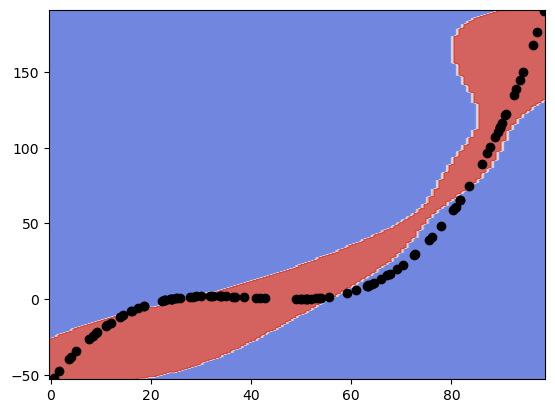

43 classification errors


In [60]:
visualize_one(model2, df3)
count = 0
for i in np.arange(0, 100):
    if model2.predict([[i, f3(i)]]) != [[1]]: 
        count += 1
print("{} classification errors".format(count))

*Question 6:* You might have noticed that I fixed the random seed -- and thus the example -- for these problems. What can happen randomly in problem 5 that I was trying to avoid? Demonstrate below. 

In [63]:
# Demonstrate the problem here
# BEGIN SOLUTION
# Remove the random seed and generate the dataset multiple times to observe changes
def demonstrate_unfixed_seed():
    total_errors = []

    for _ in range(5):  # Run 5x
        # Generate data w/out a fixed seed
        x3 = np.random.uniform(0, 100, 100)
        y3 = f3(x3)
        df3 = pd.DataFrame({'x': x3, 'y': y3})

        # Fit and predict with the 1-class SVM model
        model2.fit(df3[['x', 'y']].values)
        y_pred = model2.predict(df3[['x', 'y']].values)
        errors = (y_pred != 1).sum()  # Count classification errors

        total_errors.append(errors)
        print(f"Run {_+1}: {errors} classification errors")

    # Display variability in classification errors across runs
    print("Classification errors across runs:", total_errors)

demonstrate_unfixed_seed()

Run 1: 10 classification errors
Run 2: 32 classification errors
Run 3: 29 classification errors
Run 4: 16 classification errors
Run 5: 13 classification errors
Classification errors across runs: [10, 32, 29, 16, 13]
